In [23]:
import os
import glob
import numpy as np
import pandas as pd
import copy
import mne
from fooof import FOOOF, FOOOFGroup
import re
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Data Wrangling

In [24]:
df_localization = pd.read_csv('/Volumes/Nexus/Users/zouj/sEEG_data/electrode-localizations.tsv', delimiter='\t')\
    [['Subject', 'label', 'electrode', 'is_thalamic', 'is_cortical']]

In [25]:
spectra_file_names = glob.glob('/Volumes/Nexus/Users/zouj/sEEG_data/spectra/*')
ch_dict = {}
for spectra_file in spectra_file_names:
    subject_pattern = r'EM\d{4}'
    subject = re.findall(subject_pattern, os.path.basename(spectra_file))[0]
    if subject not in ch_dict:
        spectra = mne.time_frequency.read_spectrum(spectra_file)
        ch_dict[subject] = spectra.ch_names

In [26]:
file_basenames = [os.path.basename(file_path) 
                  for file_path in glob.glob('/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/fooof*100*/fits/*')]

In [7]:
dir_list = [
            #'/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/fooof_1-100hz_r4_bw1_pw25/fits',
            '/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/fooof_1-150hz_r4_bw1_pw25/fits',
            '/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/fooof_1-200hz_r4_bw1_pw25/fits',
            '/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/fooof_1-250hz_r4_bw1_pw25/fits']

In [27]:
results_df_list = []
for dir in dir_list:
    dir_name = os.path.basename(os.path.dirname(dir))
    for file in file_basenames:
        subject_pattern = r'EM\d{4}'
        subject = re.findall(subject_pattern, file)[0]

        run_pattern = r'run-\d[^a-zA-Z]*'
        run = re.findall(run_pattern, file)[0][:-1]

        fg = FOOOFGroup()
        fg.load(file, dir)

        df = pd.DataFrame(np.array([fooof.aperiodic_params for fooof in fg.group_results]), 
                  columns=['offset', 'log_knee', 'exponent'])
        
        df.insert(0, 'fitting_params', dir_name)
        df.insert(1, 'Subject', subject)
        df.insert(2, 'run', run)
        df.insert(3, 'label', ch_dict[subject])

        df['r_squared'] = [fooof.r_squared for fooof in fg.group_results] 
        df['error'] = [fooof.error for fooof in fg.group_results] 

        print('adding data from', len(ch_dict[subject]), 'channels for', dir_name, subject, run)
        results_df_list.append(df)

adding data from 18 channels for fooof_1-150hz_r4_bw1_pw25 EM1021 run-01
adding data from 18 channels for fooof_1-150hz_r4_bw1_pw25 EM1021 run-02
adding data from 18 channels for fooof_1-150hz_r4_bw1_pw25 EM1021 run-03
adding data from 46 channels for fooof_1-150hz_r4_bw1_pw25 EM1023 run-02
adding data from 46 channels for fooof_1-150hz_r4_bw1_pw25 EM1023 run-01
adding data from 44 channels for fooof_1-150hz_r4_bw1_pw25 EM1029 run-01
adding data from 32 channels for fooof_1-150hz_r4_bw1_pw25 EM1002 run-1_1
adding data from 32 channels for fooof_1-150hz_r4_bw1_pw25 EM1002 run-1_2
adding data from 32 channels for fooof_1-150hz_r4_bw1_pw25 EM1035 run-1
adding data from 42 channels for fooof_1-150hz_r4_bw1_pw25 EM1061 run-01
adding data from 32 channels for fooof_1-150hz_r4_bw1_pw25 EM1063 run-01
adding data from 34 channels for fooof_1-150hz_r4_bw1_pw25 EM1066 run-01
adding data from 18 channels for fooof_1-200hz_r4_bw1_pw25 EM1021 run-01
adding data from 18 channels for fooof_1-200hz_r4_

In [28]:
df_results_all = pd.concat(results_df_list, ignore_index=True)
df_results_all.insert(1, 'freq_range', [params.split('_')[1] for params in df_results_all['fitting_params']])

In [31]:
df_results_all.to_csv('/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/spectral_sensitivity_ap-params.csv')

In [12]:
df_results_median = df_results_all.drop(['fitting_params','run'], axis=1).\
        groupby(['freq_range', 'Subject', 'label']).\
        median( ).\
        reset_index()

In [13]:
df_results_median_pivot = df_results_median.pivot(index=['Subject', 'label'], 
                        columns='freq_range')

# Fit 
no significant difference in fit

<Axes: xlabel='freq_range', ylabel='r_squared'>

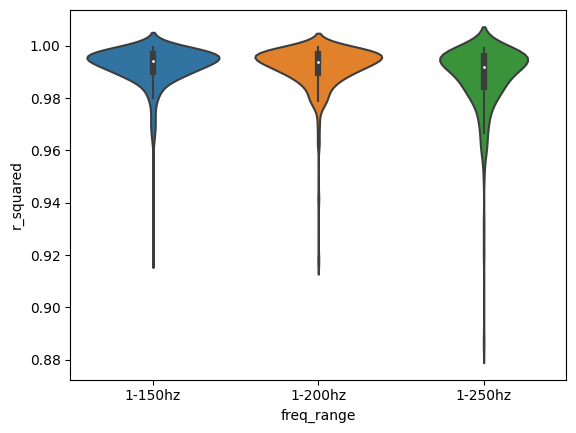

In [293]:
sns.violinplot(data=df_results_median, y="r_squared", x="freq_range")

<Axes: xlabel='freq_range', ylabel='error'>

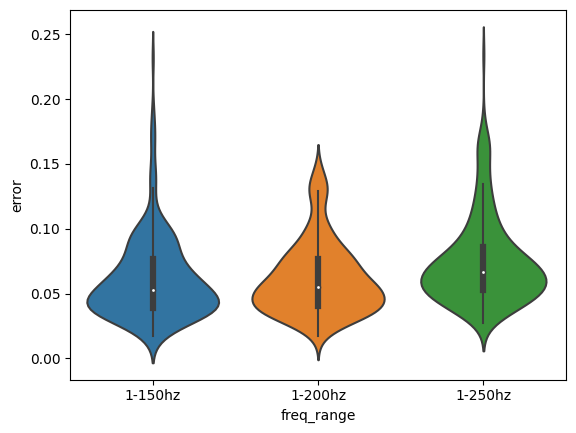

In [295]:
sns.violinplot(data=df_results_median, y="error", x="freq_range")

# Parameters 
* highly correlated
* low bias
* narrow / strong agreement intervals
    * offset < 0.3 dB
    * log knee < 0.71 --> knee ~ 3 hz with 150; knee ~ 5 hz with 250
    * exponent ~ 0.3 db/hz
    

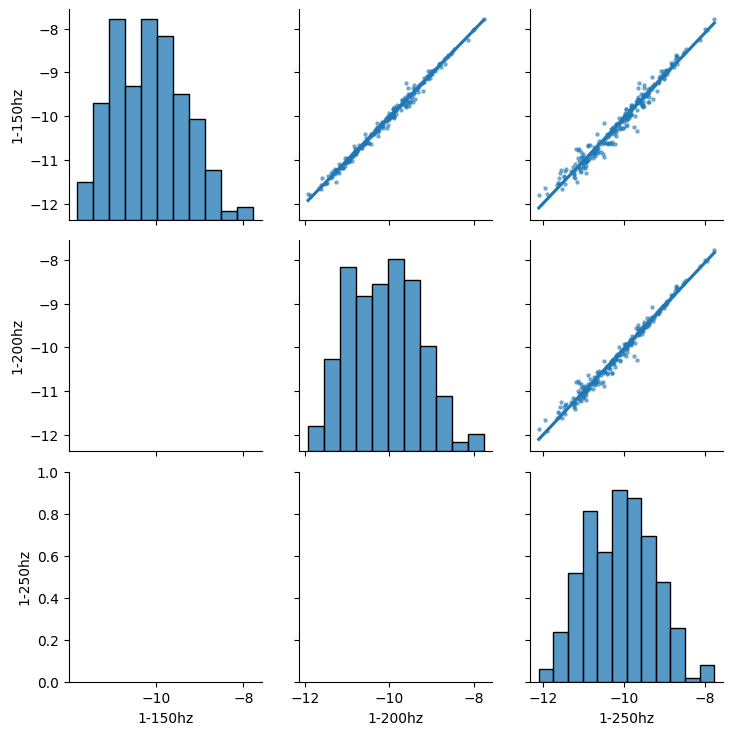

In [17]:
g = sns.PairGrid(df_results_median_pivot['offset'])
g.map_diag(sns.histplot)
g.map_upper(sns.regplot, ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

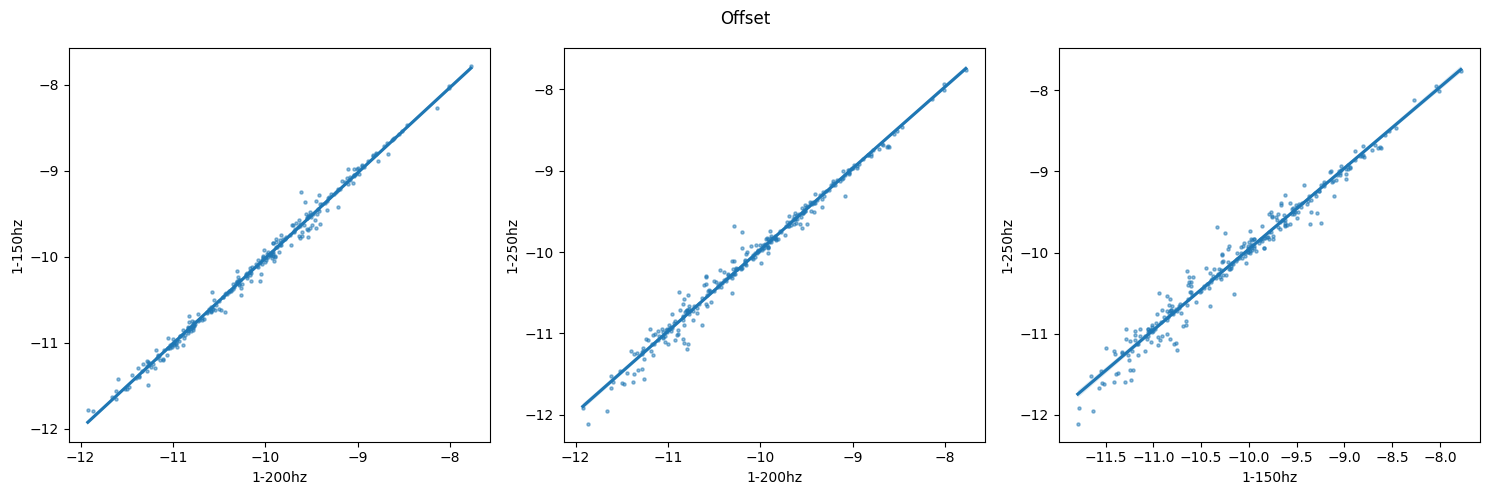

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.regplot(x=df_results_median_pivot['offset']['1-200hz'], 
            y=df_results_median_pivot['offset']['1-150hz'],
            ax=axes[0],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['offset']['1-200hz'], 
            y=df_results_median_pivot['offset']['1-250hz'],
              ax=axes[1],
              ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['offset']['1-150hz'], 
            y=df_results_median_pivot['offset']['1-250hz'], 
            ax=axes[2],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

plt.suptitle('Offset')
plt.tight_layout()
plt.show()

/Users/jasminezou/Projects/set_shifting_analysis/.venv2/lib/python3.11/site-packages/statsmodels/graphics/agreement.py:153: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/3b/c572vxrx1rddt5284f3d5zh80000gn/T/ipykernel_24174/1927702573.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


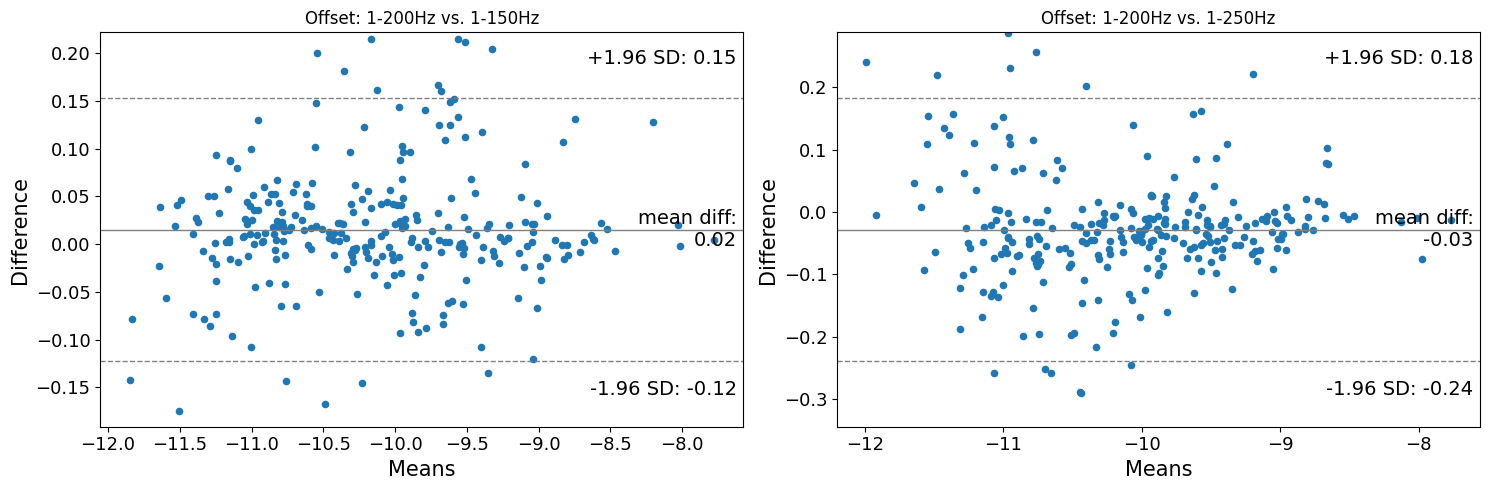

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sm.graphics.mean_diff_plot(df_results_median_pivot['offset']['1-200hz'], df_results_median_pivot['offset']['1-150hz'], ax=axes[0])
axes[0].set_title('Offset: 1-200Hz vs. 1-150Hz')

sm.graphics.mean_diff_plot(df_results_median_pivot['offset']['1-200hz'], df_results_median_pivot['offset']['1-250hz'], ax=axes[1])
axes[1].set_title('Offset: 1-200Hz vs. 1-250Hz')

plt.tight_layout()
plt.show()

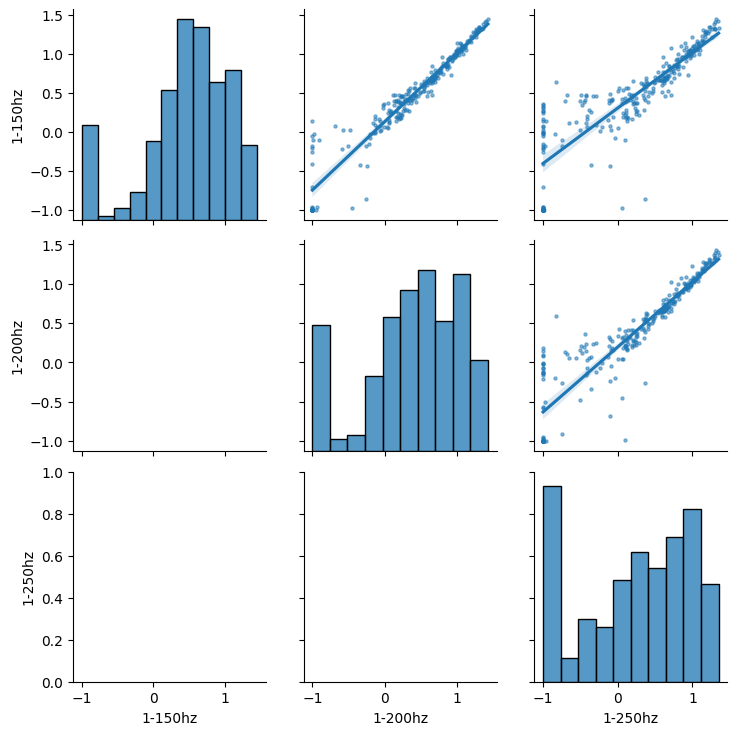

In [297]:
g = sns.PairGrid(df_results_median_pivot['log_knee'])
g.map_diag(sns.histplot)
g.map_upper(sns.regplot, ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

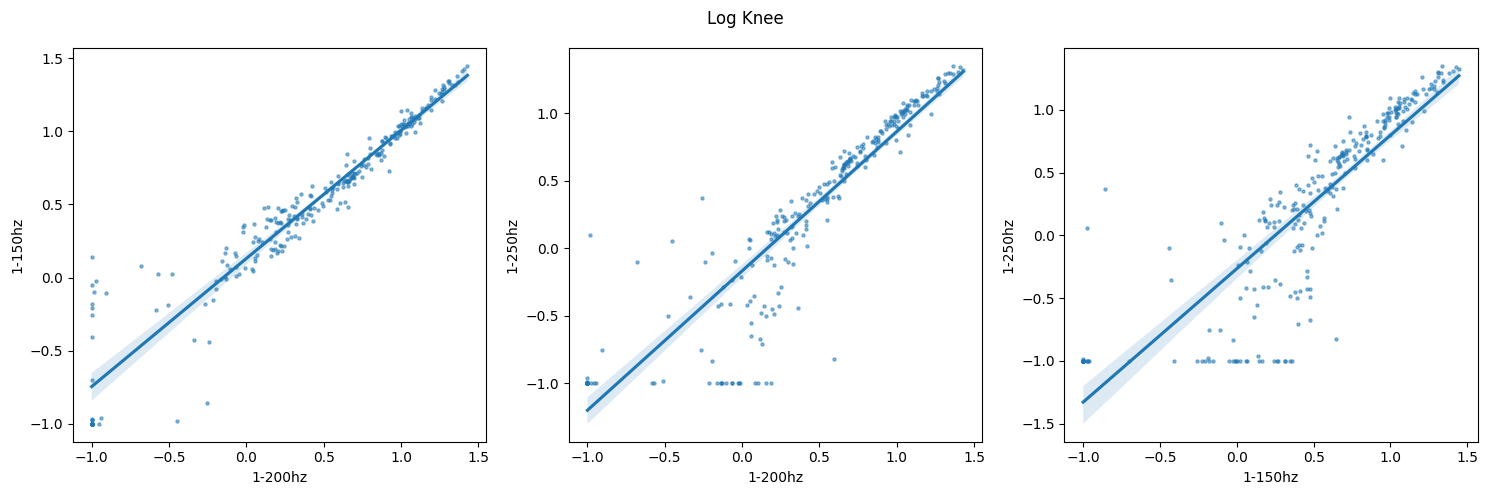

In [317]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.regplot(x=df_results_median_pivot['log_knee']['1-200hz'], 
            y=df_results_median_pivot['log_knee']['1-150hz'],
            ax=axes[0],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['log_knee']['1-200hz'], 
            y=df_results_median_pivot['log_knee']['1-250hz'],
              ax=axes[1],
              ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['log_knee']['1-150hz'], 
            y=df_results_median_pivot['log_knee']['1-250hz'], 
            ax=axes[2],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

plt.suptitle('Log Knee')
plt.tight_layout()
plt.show()

/Users/jasminezou/Projects/set_shifting_analysis/.venv2/lib/python3.11/site-packages/statsmodels/graphics/agreement.py:153: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/3b/c572vxrx1rddt5284f3d5zh80000gn/T/ipykernel_24174/3334000832.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


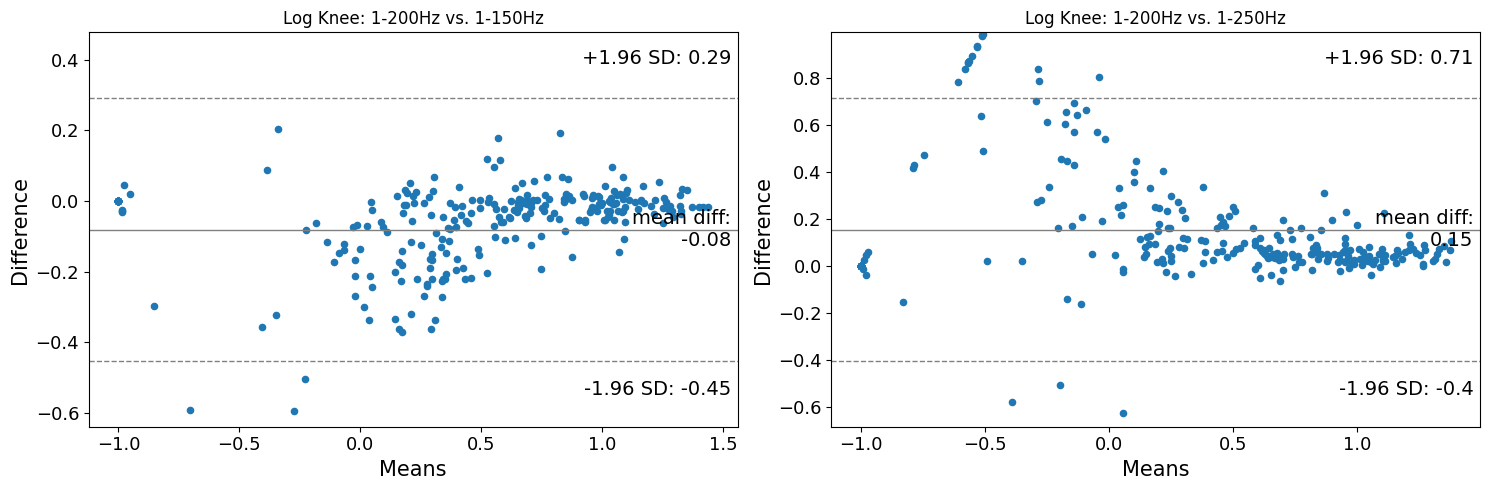

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sm.graphics.mean_diff_plot(df_results_median_pivot['log_knee']['1-200hz'], df_results_median_pivot['log_knee']['1-150hz'], ax=axes[0])
axes[0].set_title('Log Knee: 1-200Hz vs. 1-150Hz')

sm.graphics.mean_diff_plot(df_results_median_pivot['log_knee']['1-200hz'], df_results_median_pivot['log_knee']['1-250hz'], ax=axes[1])
axes[1].set_title('Log Knee: 1-200Hz vs. 1-250Hz')

plt.tight_layout()
plt.show()

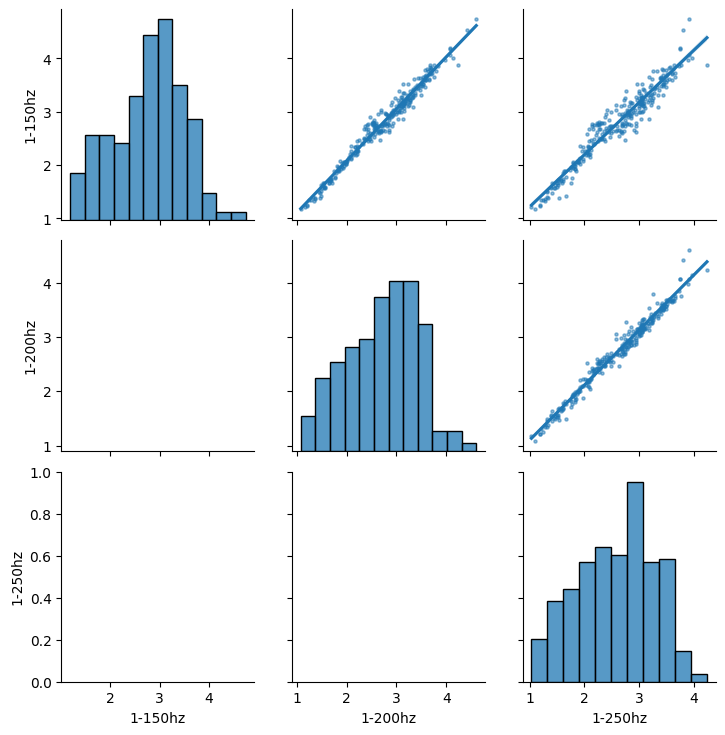

In [298]:
g = sns.PairGrid(df_results_median_pivot['exponent'])
g.map_diag(sns.histplot)
g.map_upper(sns.regplot, ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

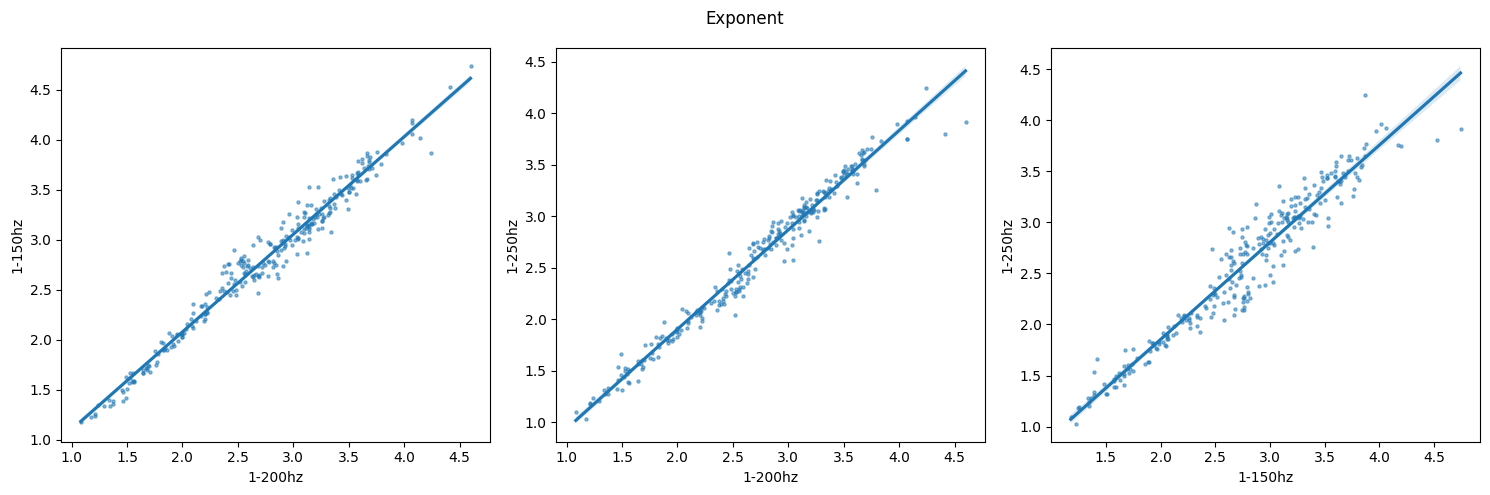

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.regplot(x=df_results_median_pivot['exponent']['1-200hz'], 
            y=df_results_median_pivot['exponent']['1-150hz'],
            ax=axes[0],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['exponent']['1-200hz'], 
            y=df_results_median_pivot['exponent']['1-250hz'],
              ax=axes[1],
              ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

sns.regplot(x=df_results_median_pivot['exponent']['1-150hz'], 
            y=df_results_median_pivot['exponent']['1-250hz'], 
            ax=axes[2],
            ci = 95, scatter_kws = {'s': 5, 'alpha': 0.5})

plt.suptitle('Exponent')
plt.tight_layout()
plt.show()

/Users/jasminezou/Projects/set_shifting_analysis/.venv2/lib/python3.11/site-packages/statsmodels/graphics/agreement.py:153: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/3b/c572vxrx1rddt5284f3d5zh80000gn/T/ipykernel_24174/378270642.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


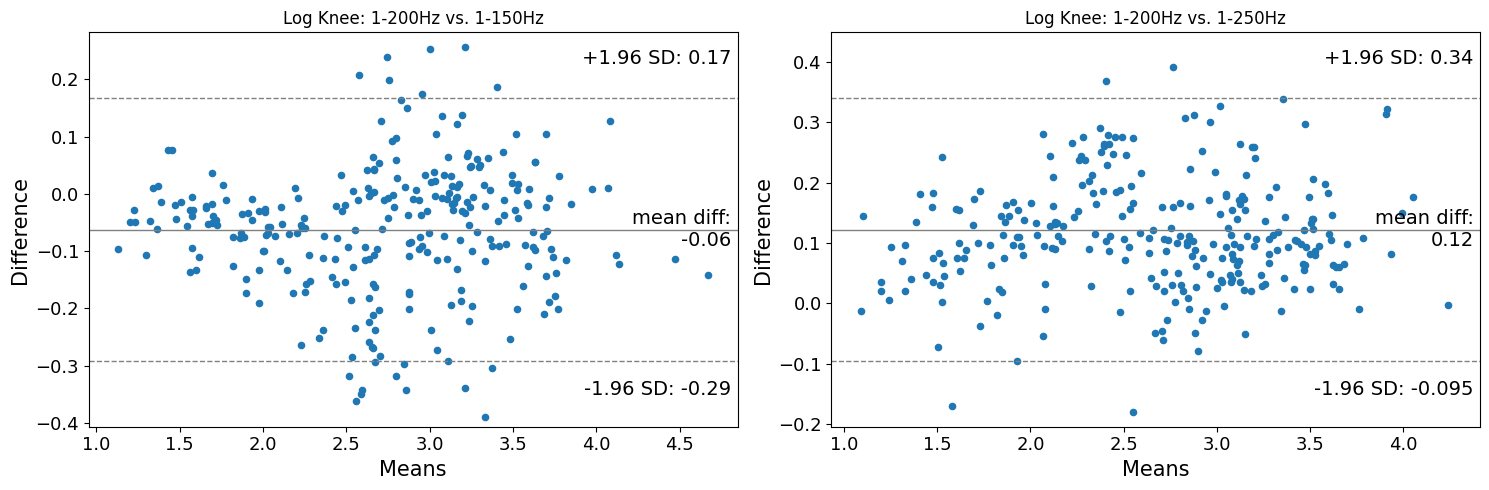

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sm.graphics.mean_diff_plot(df_results_median_pivot['exponent']['1-200hz'], df_results_median_pivot['exponent']['1-150hz'], ax=axes[0])
axes[0].set_title('Log Knee: 1-200Hz vs. 1-150Hz')

sm.graphics.mean_diff_plot(df_results_median_pivot['exponent']['1-200hz'], df_results_median_pivot['exponent']['1-250hz'], ax=axes[1])
axes[1].set_title('Log Knee: 1-200Hz vs. 1-250Hz')

plt.tight_layout()
plt.show()